## Goals:
- try training more features
- reducing over fitting
- increase accuracy

In [8]:
import os
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree

def move_data(filepath, src, dest): # Function for moving files - split training and testing data into files
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print(" " + food, end=" ")
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
        try:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
        except:
            return

In [9]:
# Create data txt files with cheesecake, ceasar salad, and chicken curry
def create_food_list(filepath, food_list_filepath, food_list):
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        
    food_list_file = open(food_list_filepath, "w")
    for p in paths:
        food = p.split('/')
        #print(food)
        if food[0] in food_list:
            food_list_file.write(p + "\n")
                #final_food_list.append(p)
    food_list_file.close()

In [10]:
food_list = ['cheesecake', 'baklava', 'carrot_cake', 'french_fries', 'churros', 'oysters', 'spring_rolls', 'sushi', 'pancakes', 'grilled_salmon']

create_food_list('meta/train.txt', 'meta/trainAllDraft2.txt', food_list)
create_food_list('meta/test.txt', 'meta/testAllDraft2.txt', food_list)

In [26]:
move_data('meta/trainAllDraft2.txt', 'images', 'Data/trainAllDraft2') 

 baklava  carrot_cake  cheesecake  churros  french_fries  grilled_salmon  oysters  pancakes  spring_rolls  sushi 

In [25]:
move_data('meta/testAllDraft2.txt', 'images', 'Data/testAllDraft2') 

 baklava  carrot_cake  cheesecake  churros  french_fries  grilled_salmon  oysters  pancakes  spring_rolls  sushi 

## Getting Image Data Ready

In [27]:
import tensorflow as tf

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [28]:
image_size = (235, 235)
batch_size = 16

train_gen = data_gen.flow_from_directory('Data/trainAllDraft2', target_size=image_size, batch_size=batch_size) # class_mode default categorical
test_gen = data_gen.flow_from_directory('Data/testAllDraft2', target_size=image_size, batch_size=batch_size)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [32]:
image_shape = (235, 235, 3)

## Load InceptionV3

In [33]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False) # include top freeze weights
inception_model.trainable=False # don't retrain weights - transfer learn

## Model 1

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

model1 = Sequential()
model1.add(inception_model)
model1.add(Dropout(0.2))
model1.add(Conv2D(32, 3, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
model1.add(Dropout(0.2))
model1.add(GlobalAveragePooling2D()) # avg output of feature map
model1.add(Dense(10, activation='softmax'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 2048)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 4, 4, 32)          589856    
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 22,392,970
Trainable params: 590,186
Non-trainable params: 21,802,784
____________________________________

In [35]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='models/draft2/model1.h5', verbose=1, save_best_only=True, save_weights_only=True)

In [43]:
history1 = model1.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
469/469 [==============================] - 161s 343ms/step - loss: 0.8287 - accuracy: 0.7372 - val_loss: 0.9063 - val_accuracy: 0.7452

Epoch 00001: val_loss improved from inf to 0.90625, saving model to models/draft2\model1.h5
Epoch 2/30
469/469 [==============================] - 177s 377ms/step - loss: 0.7936 - accuracy: 0.7417 - val_loss: 0.8877 - val_accuracy: 0.7376

Epoch 00002: val_loss improved from 0.90625 to 0.88770, saving model to models/draft2\model1.h5
Epoch 3/30
469/469 [==============================] - 171s 365ms/step - loss: 0.7247 - accuracy: 0.7589 - val_loss: 0.9316 - val_accuracy: 0.7244

Epoch 00003: val_loss did not improve from 0.88770
Epoch 4/30
469/469 [==============================] - 169s 360ms/step - loss: 0.6897 - accuracy: 0.7763 - val_loss: 0.8773 - val_accuracy: 0.7368

Epoch 00004: val_loss improved from 0.88770 to 0.87728, saving model to models/draft2\model1.h5
Epoch 5/30
469/469 [==============================] - 167s 357ms/step - loss:

In [44]:
# Save model
model1.save("models/draft2/model1.h5")

## Plot

<AxesSubplot:>

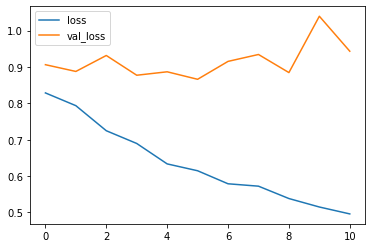

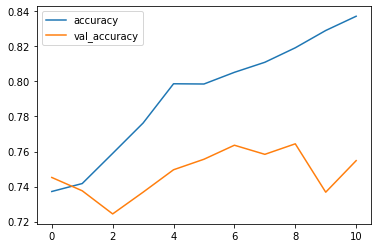

In [45]:
import pandas as pd

history_df = pd.DataFrame(history1.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [46]:
print(max(history_df['val_accuracy']))

0.7644000053405762


## Convert to tf lite

In [47]:
import tensorflow as tf
assert tf.__version__.startswith('2')

In [48]:
pip install tensorflow==2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2
ERROR: No matching distribution found for tensorflow==2


In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
with open('modelIN10features.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ariel\AppData\Local\Temp\tmp6xz4jmhv\assets


In [51]:
print(train_gen.class_indices)

{'baklava': 0, 'carrot_cake': 1, 'cheesecake': 2, 'churros': 3, 'french_fries': 4, 'grilled_salmon': 5, 'oysters': 6, 'pancakes': 7, 'spring_rolls': 8, 'sushi': 9}


In [52]:
labels = '\n'.join(sorted(train_gen.class_indices.keys()))

In [53]:
labels

'baklava\ncarrot_cake\ncheesecake\nchurros\nfrench_fries\ngrilled_salmon\noysters\npancakes\nspring_rolls\nsushi'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(history1)
tflite_model = converter.convert()
with open('models/draft2/model1.tflite', 'wb') as f:
  f.write(tflite_model)